# What is the optimal action for short-term FX transactions between SG and MYR?

Imagine the following: 

1. You have to move a non-trivial sum of $$ from SGD to MYR. 
2. This has to happen within the next 12 months. 

This is balanced against the following:
- The funds are currently in a unit trust doing its job. But at the moment, the markets aren't that great....
- If transferred, the funds will then be in a `fixed deposit` or `money market` fund. 

As the responsible adult, you need to make a decision. You want to maximize the net gain such that:

$$
\begin{align}
y = t*r_1 + (d-t)*r_2 + e
\end{align}
$$ 

where
- y: net gain (in %)
- t: time period of time in SGD (in days)
- d: total period of time till funds in needed (in days)
- r1: rate of return in SGD (in days)
- r2: rate of return in MYR (in days)
- e: exchange rate change from present rate (assumeed to be SGD->MYR 3.35)


You are starting to sweat. This decision feels like a game of luck because WHO KNOWS WHAT THE FUTURE HOLDS?! 



## `e`: How volatile are the FX Rates?

The first step is understanding the problem: how volatile are the FX rates? What exactly is at stake? 



In [9]:
# Get the FX rates of SGD->MYR for the past 6 months
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import requests
from pprint import pprint

API_URL = "https://www.alphavantage.co/query"
API_KEY = "0SBRTSPM95BI6E5J"

start_date = "2024-03-01"
end_date = "2024-09-01"
parameters = {
    "function": "FX_DAILY",
    "from_symbol": "SGD",
    "to_symbol": "MYR",
    "datatype": "json",
    "apikey": API_KEY,
}

response = requests.get(API_URL,parameters).json()

pprint(
    response["Meta Data"]
)

{'1. Information': 'Forex Daily Prices (open, high, low, close)',
 '2. From Symbol': 'SGD',
 '3. To Symbol': 'MYR',
 '4. Output Size': 'Compact',
 '5. Last Refreshed': '2024-09-20',
 '6. Time Zone': 'UTC'}


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def to_pandas(data):
    time_series = data['Time Series FX (Daily)']
    df = pd.DataFrame.from_dict(time_series).transpose()
    df = df.rename(columns={
        '1. open': 'open', 
        '2. high': 'high', 
        '3. low': 'low', 
        '4. close': 'close'
        })
    
    # Type casting
    for col in df:
        df[col] = df[col].astype(float)
    df.index = pd.to_datetime(df.index)
    
    df.sort_index(ascending=False, inplace=True)

    # Calculate volatility
    df["log_return"] = np.log(df['close'] / df['close'].shift(1))
    df["volatility"] = df["log_return"].rolling(window=3).std()

    print("Processed DF: ")
    print(df.head())
    print(df.tail())


    return df

df = to_pandas(response)

# sns.lineplot(x="date", y="value", data=df)

Processed DF: 
              open    high     low   close  log_return  volatility
2024-09-20  3.2582  3.2589  3.2574  3.2578         NaN         NaN
2024-09-19  3.2786  3.2913  3.2499  3.2549   -0.000891         NaN
2024-09-18  3.2901  3.2933  3.2710  3.2792    0.007438         NaN
2024-09-17  3.3195  3.3198  3.2834  3.2834    0.001280     0.00432
2024-09-16  3.3148  3.3219  3.3138  3.3201    0.011115     0.00497
              open    high     low   close  log_return  volatility
2024-05-10  3.4990  3.5041  3.4981  3.4981    0.000572    0.002155
2024-05-09  3.4989  3.5023  3.4921  3.5021    0.001143    0.000587
2024-05-08  3.5003  3.5010  3.4956  3.4983   -0.001086    0.001158
2024-05-07  3.5077  3.5105  3.4977  3.4977   -0.000172    0.001120
2024-05-06  3.5105  3.5131  3.5050  3.5067    0.002570    0.001902


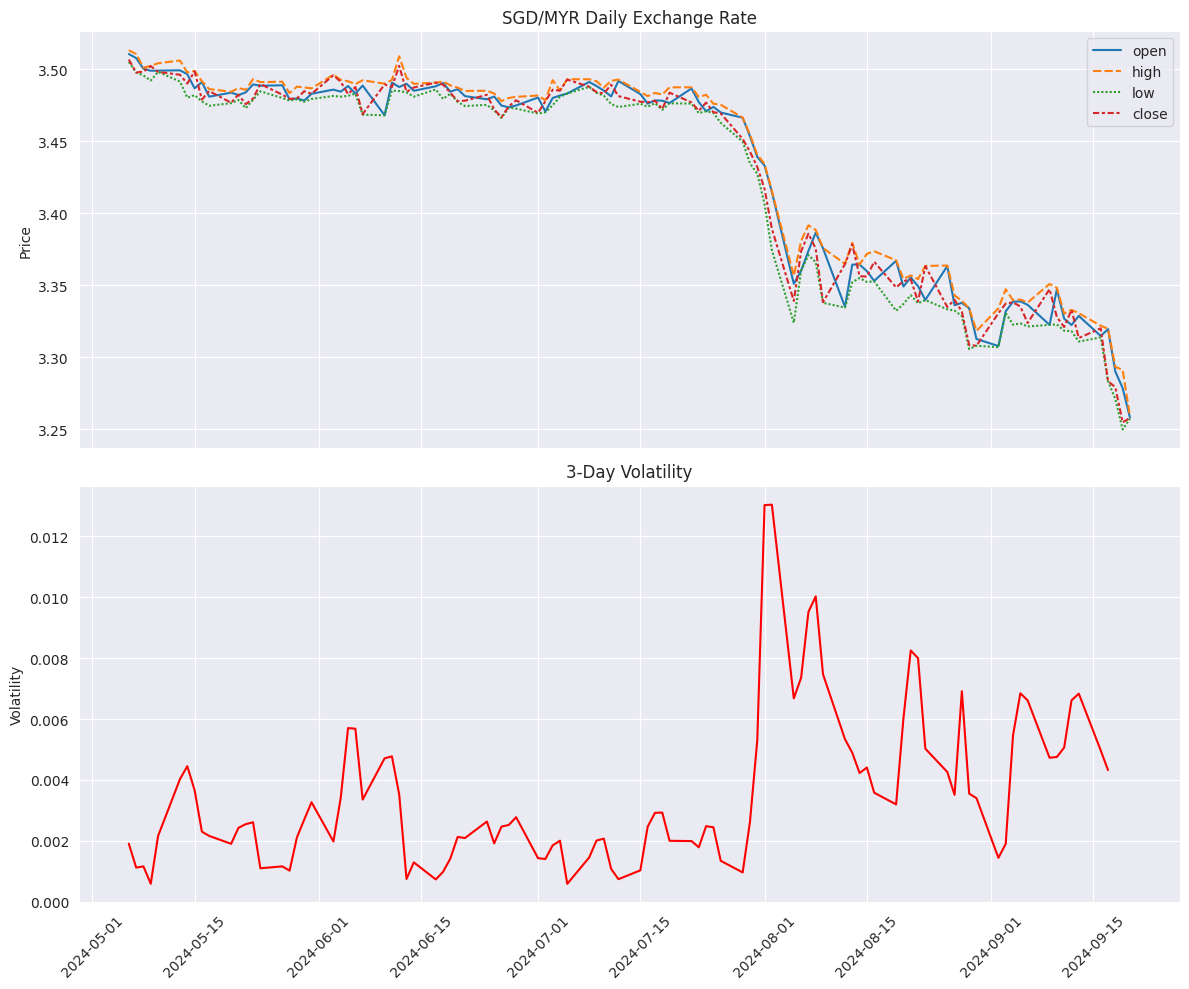

In [11]:
import matplotlib.pyplot as plt
def plot_forex_data(df):
    sns.set_style("darkgrid")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot all price data
    sns.lineplot(data=df[['open', 'high', 'low', 'close']], ax=ax1)
    ax1.set_title('SGD/MYR Daily Exchange Rate')
    ax1.set_ylabel('Price')
    
    # Plot volatility
    sns.lineplot(data=df['volatility'], ax=ax2, color='red')
    ax2.set_title('3-Day Volatility')
    ax2.set_ylabel('Volatility')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_forex_data(df)


# resample_df_to_weekly()
        index    open    high     low   close
0 2024-05-12  3.5105  3.5131  3.4921  3.4981
1 2024-05-19  3.4992  3.5060  3.4746  3.4848
2 2024-05-26  3.4837  3.4931  3.4729  3.4897
3 2024-06-02  3.4888  3.4913  3.4774  3.4829
4 2024-06-09  3.4858  3.4961  3.4684  3.4688

# melt_df_to_long()
         index variable   value
36 2024-09-01     high  3.3637
60 2024-05-12    close  3.4981
76 2024-09-01    close  3.3080
15 2024-08-25     open  3.3670
0  2024-05-12     open  3.5105
34 2024-08-18     high  3.3795
57 2024-09-08      low  3.3070
12 2024-08-04     open  3.4663
23 2024-06-02     high  3.4913
64 2024-06-09    close  3.4688


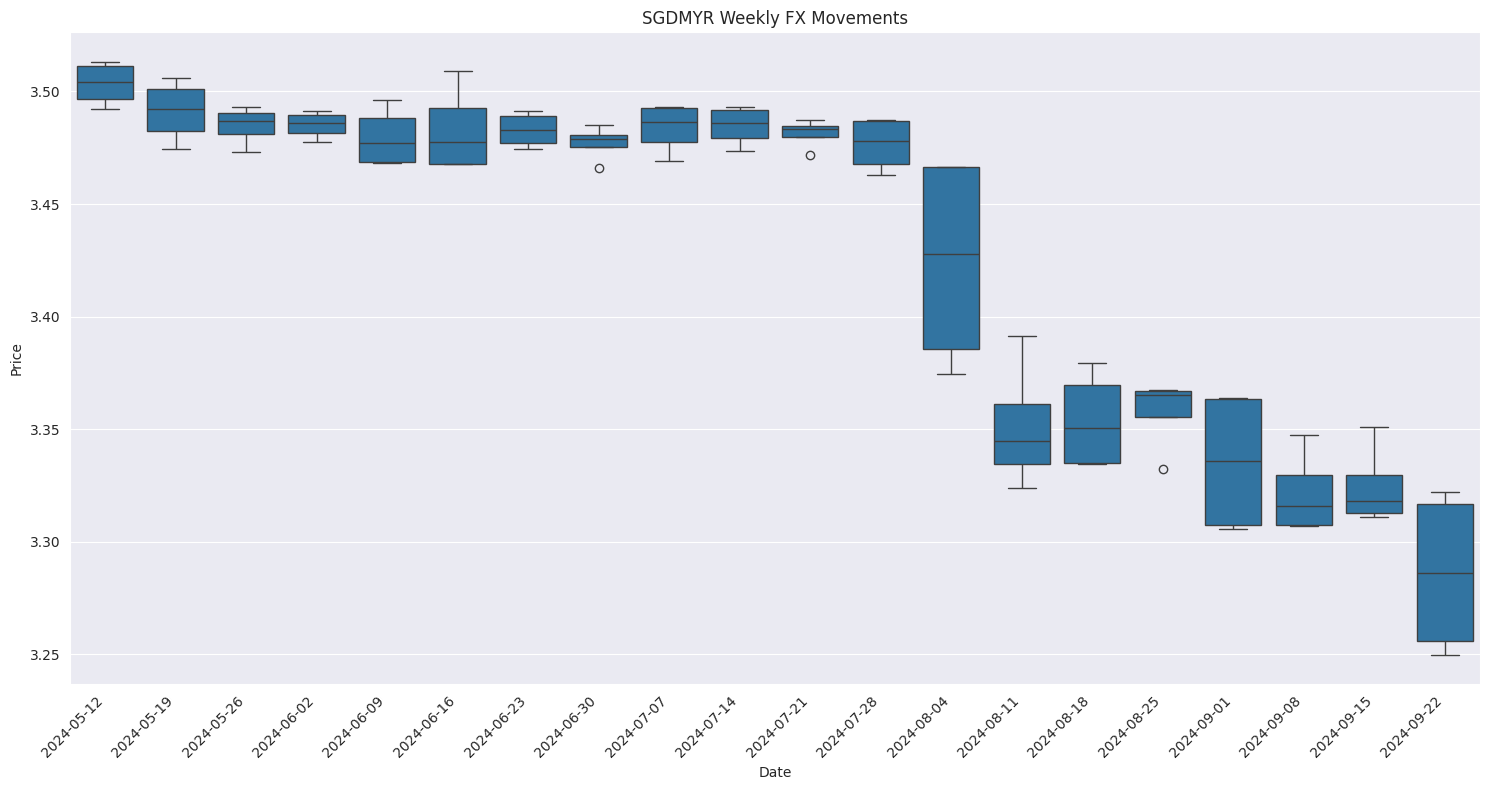

In [12]:
import inspect
import logging

def get_current_function_name():
    return "\n# " + inspect.currentframe().f_back.f_code.co_name + "()\n"

# Resample to weekly frequency
def resample_df_to_weekly(df):
    """
    This code is performing weekly resampling of the DataFrame 'df' and aggregating the data. 

    - df.resample('W'): This method resamples the DataFrame to a weekly frequency. The 'W' argument specifies weekly resampling.
    - .agg({...}): This applies different aggregation functions to specific columns.

    The dictionary inside agg() specifies how each column should be aggregated:
    - 'open': 'first' - Takes the first value of 'open' for each week
    - 'high': 'max' - Takes the maximum value of 'high' for each week
    - 'low': 'min' - Takes the minimum value of 'low' for each week
    - 'close': 'last' - Takes the last value of 'close' for each week
    """
    df = df.resample('W').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
    })
    df.reset_index(inplace=True)
    print(get_current_function_name(), df.head() )

    return df


# Melt the dataframe to long format
def melt_df_to_long(df):
    """
    This function takes a DataFrame as input and melts it into a long format.
    
    Key cols returned are: 
    - index: timeseries
    - variable: the melted column name
    - value: the value of the melted column
    """
    df = pd.melt(
    weekly_df,
    id_vars=['index'],
    value_vars=['open', 'high', 'low', 'close']
    )
    print(get_current_function_name(), df.sample(10) )
    return df

weekly_df = resample_df_to_weekly(df)
weekly_long = melt_df_to_long(weekly_df)

# Create the box plot
plt.figure(figsize=(15, 8))
sns.boxplot(data = weekly_long, x = 'index', y = 'value')

plt.title('SGDMYR Weekly FX Movements')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Parameter Estimation

In [13]:
import numpy as np

def estimate_alpha_beta(mode, fx_min, fx_max):
    # Normalize the mode
    m = (mode - fx_min) / (fx_max - fx_min)
    
    # Estimate precision
    k = 2 + (fx_max - fx_min)**(-2)
    
    # Calculate alpha and beta
    alpha = m * (k - 2) + 1
    beta = (1 - m) * (k - 2) + 1
    
    return alpha, beta

# HSBC RM opinion
fx_min, fx_max, mode = 3.25, 3.40, 3.35
alpha_est, beta_est = estimate_alpha_beta(mode, fx_min, fx_max)
print(f"Estimated alpha: {alpha_est:.4f}, Estimated beta: {beta_est:.4f}")

# Verify the mode
calculated_mode = (alpha_est - 1) / (alpha_est + beta_est - 2)
normalized_input_mode = (mode - fx_min) / (fx_max - fx_min)
print(f"Input normalized mode: {normalized_input_mode:.4f}")
print(f"Calculated normalized mode: {calculated_mode:.4f}")

Estimated alpha: 30.6296, Estimated beta: 15.8148
Input normalized mode: 0.6667
Calculated normalized mode: 0.6667


In [14]:
import numpy as np
from scipy.stats import beta
from scipy.optimize import minimize

def beta_mode(params):
    alpha, beta = params
    return (alpha - 1) / (alpha + beta - 2)

def objective(params, target_mode):
    return (beta_mode(params) - target_mode)**2

def estimate_beta_params_scipy(observed_mode, fx_min, fx_max):
    normalized_mode = (observed_mode - fx_min) / (fx_max - fx_min)
    
    # Initial guess
    initial_guess = [2, 2]
    
    # Optimization
    result = minimize(objective, initial_guess, args=(normalized_mode,), method='Nelder-Mead')
    
    return result.x

# HSBC RM opinion
fx_min, fx_max, mode = 3.25, 3.40, 3.35
alpha_scipy, beta_scipy = estimate_beta_params_scipy(mode, fx_min, fx_max)
print(f"SciPy estimated alpha: {alpha_scipy:.4f}, beta: {beta_scipy:.4f}")

SciPy estimated alpha: 2.3645, beta: 1.6822


## Parameter Estimation 

2.802642071672782 11.210568286691128


/tmp/ipykernel_108280/2352166104.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{tick:.3f}' for tick in fx_ticks])


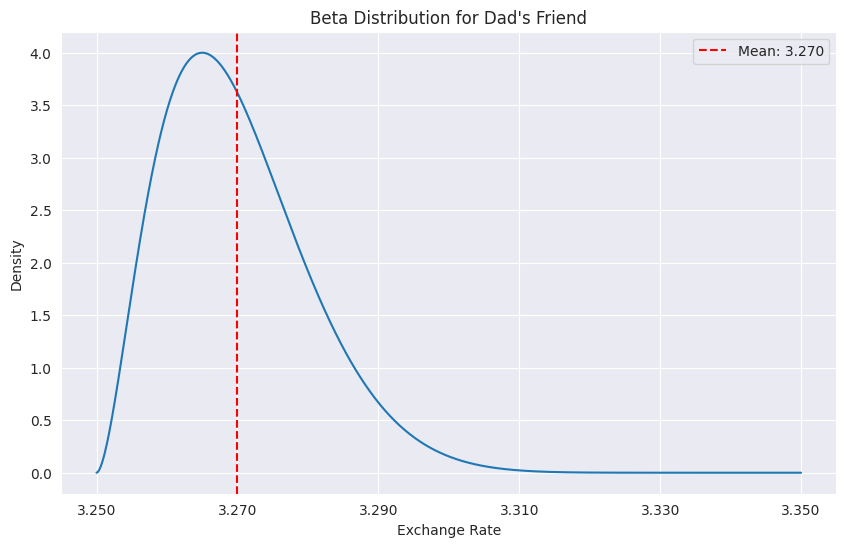

In [48]:
def estimate_parameters(fx_high, fx_low, fx_expected, weight):
    """
    estimate parameters of a prior distribution.

    uses beta distributions where:
    Args:
        fx_high: expert opinon on upper bound of fx
        fx_low: expert opinon on lower bound of fx rate
        fx_expected: expert opinon on expected fx rate
        weight: weight of expert opinon, should be between 0 and 1 where 1 is most confident

    Returns:
        alpha and beta parameters of beta distribution
    """
    mu_norm = (fx_expected - fx_low) / (fx_high - fx_low)
    var = (1.001-weight**0.5) * 0.1
    alpha = (
        (1-mu_norm) / var
        - 1 / mu_norm
    ) * mu_norm ** 2

    beta = alpha * (1 / mu_norm - 1)
    return alpha, beta

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_beta_dist(alpha_est, beta_est, fx_low, fx_high, expert_name):
    x = np.linspace(0, 1, 1000)
    y =beta.pdf(x, alpha_est, beta_est)
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=x, y=y)
    
    # Convert x-axis from [0,1] back to FX rate range
    xticks = plt.gca().get_xticks()
    fx_ticks = fx_low + xticks * (fx_high - fx_low)
    plt.gca().set_xticklabels([f'{tick:.3f}' for tick in fx_ticks])
    
    plt.title(f'Beta Distribution for {expert_name}')
    plt.xlabel('Exchange Rate')
    plt.ylabel('Density')
    
    # Add vertical line for the mean
    mean = alpha_est / (alpha_est + beta_est)
    mean_fx = fx_low + mean * (fx_high - fx_low)
    plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean_fx:.3f}')
    
    plt.legend()
    plt.show()

# Example usage
fx_low, fx_high, fx_expected = 3.25, 3.35, 3.27
alpha_est, beta_est = estimate_parameters(fx_high, fx_low,fx_expected, 0.8 )
print(alpha_est, beta_est)
expert_name = "Dad's Friend"
plot_beta_dist(alpha_est, beta_est, fx_low, fx_high, expert_name)


20479.999999999964 5119.99999999999


/tmp/ipykernel_108280/3098710793.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{tick:.4f}' for tick in fx_values[::len(x)//10]])


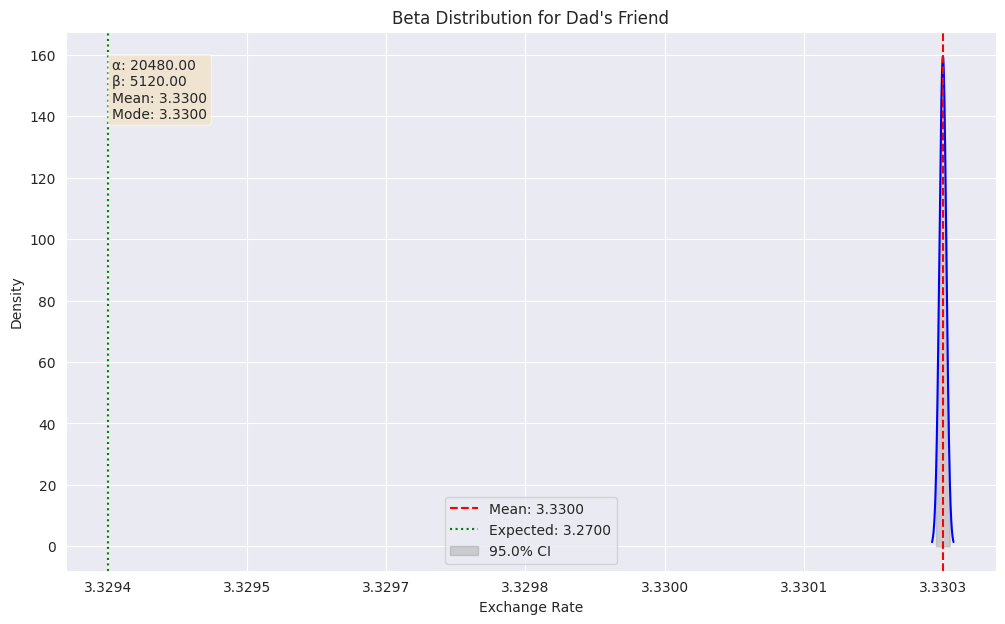

In [23]:
import scipy.stats as stats
import scipy.optimize as optimize

def estimate_parameters_v2(fx_low, fx_high, fx_expected, weight, ci=0.95):
    range_width = fx_high - fx_low
    normalized_expected = (fx_expected - fx_low) / range_width
    
    # Initial variance estimate
    variance = ((1 - weight) * range_width / 4) ** 2
    
    def beta_ci_diff(params):
        a, b = params
        return (stats.beta.cdf(1, a, b) - stats.beta.cdf(0, a, b)) - ci
    
    def optimize_func(params):
        a, b = params
        mean_diff = abs(a / (a + b) - normalized_expected)
        ci_diff = abs(beta_ci_diff(params))
        return mean_diff + ci_diff

    # Initial guess
    initial_guess = [normalized_expected / variance, (1 - normalized_expected) / variance]
    
    # Optimize
    result = optimize.minimize(optimize_func, initial_guess, method='Nelder-Mead')
    
    return result.x[0], result.x[1]

def plot_beta_dist_v2(a, b, fx_low, fx_high, fx_expected, expert_name, ci=0.95):
    plt.figure(figsize=(12, 7))
    
    # Generate x values
    x = np.linspace(beta.ppf(0.001, a, b), beta.ppf(0.999, a, b), 1000)
    
    # Calculate PDF
    y = beta.pdf(x, a, b)
    
    # Plot the distribution
    sns.lineplot(x=x, y=y, color='blue')
    
    # Convert x-axis from [0,1] to FX rate range
    fx_range = fx_high - fx_low
    fx_values = fx_low + x * fx_range
    
    # Set x-axis to show FX rates
    plt.gca().set_xticklabels([f'{tick:.4f}' for tick in fx_values[::len(x)//10]])
    
    # Add vertical lines for important values
    mean = a / (a + b)
    mean_fx = fx_low + mean * fx_range
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean_fx:.4f}')
    plt.axvline((fx_expected - fx_low) / fx_range, color='green', linestyle=':', label=f'Expected: {fx_expected:.4f}')
    
    # Add CI area
    ci_low, ci_high = beta.ppf([(1-ci)/2, (1+ci)/2], a, b)
    plt.fill_between(x, 0, y, where=(x >= ci_low) & (x <= ci_high), alpha=0.3, color='gray', label=f'{ci*100}% CI')
    
    plt.title(f'Beta Distribution for {expert_name}')
    plt.xlabel('Exchange Rate')
    plt.ylabel('Density')
    plt.legend()
    
    # Add text box with distribution details
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = f'α: {a:.2f}\nβ: {b:.2f}\nMean: {mean_fx:.4f}\nMode: {fx_low + (a-1)/(a+b-2)*fx_range:.4f}'
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.show()

fx_low, fx_high, fx_expected = 3.25, 3.35, 3.27
alpha_est, beta_est = estimate_parameters_v2(fx_high, fx_low,fx_expected, 0.75 )
print(alpha_est, beta_est)
expert_name = "Dad's Friend"
plot_beta_dist_v2(alpha_est, beta_est, fx_low, fx_high, fx_expected, expert_name)

Excellent question. The relationship between alpha (a), beta (b), and the normalized expected value is rooted in the properties of the beta distribution. Let's explore this further:

For a beta distribution, the mean μ should match the normalized expected value (E), so: 

$$\mu = E = \frac{\alpha}{\alpha + \beta}$$

The sum of α and β is also a measure of the concentration of the distribution.
The higher the concentration, the more likely we are to get values close to the mean from the distribution.
In simple terms, its a measure of "certainty" in the expert's opinion.

$$
\alpha + \beta  = c

Therefore:
\alpha = cE 

\beta = c(1-E)
$$ 


Here are alternative ways to derive the same result:

**Method of Moments**

- Mean of beta distribution: $μ = α / (α + β)$
- Variance of beta distribution: $σ² = αβ / ((α + β)²(α + β + 1))$
- If we solve these equations for $α$ and $β$ given $μ$ and $σ²$, we get: $α = μ(μ(1-μ)/σ² - 1)$ and $β = (1-μ)(μ(1-μ)/σ² - 1)$

Our simplified approach is essentially setting $(μ(1-μ)/σ² - 1)$ to our concentration parameter.

**Maximum Likelihood Estimation**

For beta distribution, MLE doesn't have a closed-form solution, but it converges to the method of moments for large sample sizes.

These derivations support our simplified approach, which captures the essence of the expert's opinion while maintaining mathematical consistency with the properties of the beta distribution.

## "Concentration" as a measure of peakedness
Here are some key heuristics and interpretations:

- Higher c values (e.g., 100+) indicate high certainty, resulting in narrow, peaked distributions.
- Lower c values (e.g., 1-10) suggest low certainty, leading to flatter, more spread-out distributions.
- A c value of 2 represents a uniform distribution, indicating maximum uncertainty.
- As c approaches infinity, the distribution approximates a normal distribution.

To calibrate c effectively:

- Use domain expertise: Map expert confidence levels to c values based on historical accuracy.
- Empirical testing: Analyze past predictions to correlate confidence levels with appropriate c values.
- Sensitivity analysis: Test different c values and observe their impact on decision-making processes.
- Benchmark against other uncertainty measures: Compare c values with other established certainty metrics in your field.
- Iterative refinement: Regularly update your calibration based on new data and outcomes.

For the forex context, you might start with a range of c values like:
Low confidence: c = 10-30
Medium confidence: c = 30-70
High confidence: c = 70-100+

15.200000000000001 3.799999999999999


/tmp/ipykernel_108280/2002031726.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{tick:.3f}' for tick in fx_ticks])


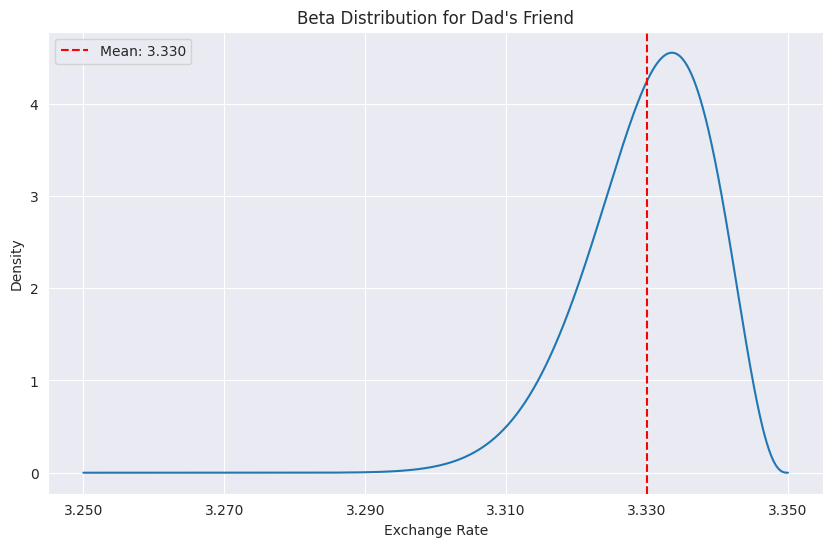

In [32]:
def estimate_parameters_v3(fx_low, fx_high, fx_expected, weight):
    range_width = fx_high - fx_low
    normalized_expected = (fx_expected - fx_low) / range_width
    
    # Use weight directly to control the concentration
    concentration = 10 + 90 * weight  # This will give c values between 10 and 100
    
    alpha = concentration * normalized_expected
    beta = concentration * (1 - normalized_expected)
    
    return alpha, beta

# Test the new function
fx_low, fx_high, fx_expected = 3.25, 3.35, 3.27
alpha_est, beta_est =estimate_parameters_v3(fx_high, fx_low,fx_expected, 0.1 )
print(alpha_est, beta_est)
expert_name = "Dad's Friend"
plot_beta_dist(alpha_est, beta_est, fx_low, fx_high,expert_name)